# I - Bayesian inference on a logistic regression model

Here we aim at reproducing experiments from the papers on Riemanian Manifold Hamiltonian Monte Carlo [1, 2]. We use this methods in the context of Bayesian inference on logisitic regression model : 
\begin{equation}
    \log p(y, \beta | X, \alpha ) = \beta^T X^T y-\sum_{i = 1}^N \log\left(1 + \exp(\beta^TX_{n, \cdot}^T)\right)- \frac{1}{2\alpha}\beta^T\beta
\end{equation}
Where $X$ is a matrix of features, $\beta$ is the parameter we are tying to infer with a normal prior $\mathcal{N}(0, \alpha I)$, and $y \sim \mathcal{B}(\sigma(X\beta))$ is the observed variable allong with the matrix of features.

### Generation of a synthetic dataset

In [8]:
import torch
from torch.nn.functional import sigmoid

# # Many features on MPS are not stable... Including eighenvalue decomposition
# # Set device to Apple Metal if available
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     torch.set_default_device(mps_device)
#     print("MPS device found.")
#     print(f"Default device set to: {torch.get_default_device()}")
# else:
#     print ("MPS device not found.")
#     print(f"Default device set to : {torch.get_default_device()}")

In [9]:
def generate_data(N_data : int, N_features : int, generator : torch.Generator) -> dict[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate a synthetic dataset of the Bayesian Logistic model.

    Args:
        N_data (int): Number of data points.
        N_features (int): Number of features (excluding the bias). 
        generator (torch.Generator): Random number generator for reproducibility. 

    Returns:
        dict[torch.Tensor, torch.Tensor, torch.Tensor]: A dictionary containing the generated data with features and parameters : 
        - 'x' (torch.Tensor) : feature matrix of shape (N_feature + 1, N_data) to include the bias. 
        - 'beta' (torch.Tensor) : parameter matrix of shape (N_feature + 1,) to include the bias. 
        - 'y' (torch.Tensor) : data matrix of shape (N_data,)
    """
    x = torch.cat([
        torch.ones(N_data, 1), 
        torch.randn(N_data, N_features, generator= generator)
    ], dim = 1)
    beta = torch.randn(N_features+1, generator = generator)
    probas = sigmoid(x@beta)
    y = torch.bernoulli(probas, generator = generator)
    return {
        "x":x, 
        "beta" : beta, 
        "y" : y
    }

In [10]:
N_data = 10
N_features = 1

generator = torch.Generator(device = torch.get_default_device())
data_dict = generate_data(N_data, N_features, generator)

features = data_dict["x"]
beta_gt = data_dict["beta"]
data = data_dict["y"]

### Definition of the Fisher-Rao cometric

In [11]:
# # The import of torch.diffeq within CoMetric is causing an error because it uses float64 dtype that are not supported by MPS
# with torch.device("cpu"):
#     from geodesic_toolbox import CoMetric

from geodesic_toolbox import CoMetric


class FisherRaoBLR(CoMetric):
    """Class for the Fisher-Rao cometric associated to the Bayesian Logistic Regression model with a gaussian pior from equation (28) in [1]: 
        G(beta) = X^T Lambda X + alpha^{-1} I

    where X is a matrix of features and alpha is a variance in the prior on the parameter. 
    Alpha also acts as a regularization factor in the metric. 
    
    Attibutes:
        alpha (torch.Tensor) : Variance of the prior on beta of shape (1,)
        features (torch.Tensor) : Matrice of features of shape (N_data, N_features + 1) to include the bias. 
        N_data (int) : Number of data points.
        N_features (int) : Number of features (excluding the bias). 

        **Inherited Attributes:**
       See :class:`CoMetric` for base CoMetric parameters 
    
    References : 
        [1] Girolami, M., & Calderhead, B. (2011). Riemann Manifold Langevin and Hamiltonian Monte Carlo Methods. Journal of the Royal Statistical Society Series B: Statistical Methodology, 73(2), 123–214. https://doi.org/10.1111/j.1467-9868.2010.00765.x

    """

    def __init__(self, features : torch.Tensor, alpha : torch.Tensor):
        super().__init__(is_diag = False)
        self.alpha = alpha
        self.features = features
        self.N_data = features.shape[0]
        self.N_features = features.shape[1]-1
    
    def logit_p(self, beta : torch.Tensor) -> torch.Tensor : 
        """Computes the predicted logit probabilities for a given parameter beta : logit_p(beta) = X@beta.

        Args:
            beta (torch.Tensor): (Batch of) parameters of shape (N_batch, N_features + 1) to include bias.

        Returns:
            torch.Tensor: (Batch of) predicted logit probabilities of shape (N_batch, N_data).
        """
        return beta @ self.features.T


    def p(self, beta : torch.Tensor) -> torch.Tensor: 
        """Computes the predicted probabilities for a given parameter beta : p = sigmoid(X@beta)

        Args:
            beta (torch.Tensor): (Batch of) parameters of shape (N_batch, N_features + 1) to include bias.

        Returns:
            torch.Tensor: (Batch of) predicted probabilities of shape (N_batch, N_data). 
        """
        logit_p = self.logit_p(beta)
        return sigmoid(logit_p)

    def metric_tensor(self, beta: torch.Tensor) -> torch.Tensor:
        """Computes the metric tensor G(beta) as in [1] equation (28).

        Args:
            beta (torch.Tensor): (Batch of) parameters of shape (N_Batch, N_features + 1) to include bias.

        Returns:
            torch.Tensor: (Batch of) metric tensors of shape (N_batch, N_features+1, N_features+1).
        """
        p = self.p(beta)
        lambda_diag = p*(1-p)
        hess_ll = torch.einsum("bn,ni,nj->bij", lambda_diag, self.features, self.features)
        return hess_ll + (1/self.alpha) * torch.eye(self.N_features+1)

    def forward(self, beta : torch.Tensor) -> torch.Tensor : 
        """Returns the cometric tensor by inverting equation (28) in [1].

        Args:
            beta (torch.Tensor): (Batch of) parameters of shape (N_batch, N_features + 1) to include bias.

        Returns:
            torch.Tensor: (Batch of) cometric tensors of shape (N_batch, N_features+1, N_features+1).
        """
        metric_tensor = self.metric_tensor(beta)
        return metric_tensor.inverse()


In [14]:
alpha = torch.tensor(0.1)
fisher_rao_cometric = FisherRaoBLR(features, alpha)

## 1. RM-HMC with implicit integration scheme

In this section we aim at reproducing the experiment in [1], i.e with the implicit leapfrog solver, on our synthetic dataset of Bayesian logistic regression. 

### RHMC Sampler of the posterior distribution

In [15]:
from geodesic_toolbox import ImplicitRHMCSampler

class DensityNotKnownError(Exception): 
    pass


class PosteriorImplicitRHMCSampler(ImplicitRHMCSampler):
    """Riemannian Hamiltonian Monte Carlo sampler with a pdf defined on a manifold.
    It uses the leapfrog integrator to propose new samples from the target distribution.
    It uses a tempering scheme on the momentum.
    Here the target distribution the posterior distribution of the Bayesian logistic regression model.


    Attributes:
       features (torch.Tensor) : Matrice of features of shape (N_data, N_features + 1) to include the bias. 
       data (torch.Tensor) : Observed data of shape (N_data,)
       alpha (torch.Tensor) : Variance of the prior on beta of shape (1,)
       
       **Inherited Attributes:**
       See :class:`ImplicitRHMCSampler` for base MCMC parameters 
    """

    def __init__(
        self, 
        features : torch.Tensor, 
        data : torch.Tensor, 
        alpha : torch.Tensor, 
        *args, 
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.features = features
        self.data = data
        self.alpha = alpha

    def p_target(self, beta : torch.Tensor) -> torch.Tensor :
        """ The target definition is not known is closed form because of the intractable normalizing constant p(y|beta, X, alpha).
        """
        raise DensityNotKnownError


    def U(self, beta : torch.Tensor) -> torch.Tensor : 
        """ Computes the potential energy given by the log joint likelihood : 
            U(beta) = -log p(beta, y | X, alpha)
        This equals, up to an additional constant, to the targeted log posterior log p(beta|y,X,alpha)

        Args:
            beta (torch.Tensor): (Batch of) parameters of shape (N_batch, N_features + 1) to include bias.

        Returns:
            torch.Tensor: (Batch of) energies corresponding to the parameters of shape (N_batch,)
        """
        #Likelihood term 
        lh_term = beta @ self.features.T @ self.data - torch.sum(torch.log(1 + torch.exp(beta @ self.features.T)), axis = 1)
        # Prior term
        prior_term = -0.5/self.alpha*(beta**2).sum(dim=1)
        return -(lh_term + prior_term)

In [16]:
l = 10 # Number of leapfrog steps
N_fx = 5 # Number of iteration in the fixed point method
gamma = 0.35 # Step size
N_run = 5000 # Number of Monte Carlo steps
N_chain = 1 # Number of MCMC ran in parallel


sampler = PosteriorImplicitRHMCSampler(
    features= features, 
    data = data, 
    alpha = alpha,
    cometric=fisher_rao_cometric, 
    l = l, 
    N_fx= N_fx,
    gamma = gamma,
    N_run = N_run, 
)

In [36]:
beta_0 = torch.randn(N_chain ,N_features+1, generator = generator)
traj, acc_rate = sampler.sample(beta_0, return_traj=True, return_acceptance= True, progress= True)
beta_pred = traj[:, -1, :]
rel_err = torch.sqrt(torch.sum((beta_pred-beta_gt)**2, axis = 1))/torch.linalg.norm(beta_gt) 

print(f"RM-HMC computed successfully : ")
print(f"- Accepation rate : {acc_rate}")
print(f"- Relative errors : {rel_err.tolist()}")

Sampling: 100%|██████████| 5000/5000 [08:01<00:00, 10.37steps/s, acceptance_rate=0.266]

RM-HMC computed successfully : 
- Accepation rate : 0.266
- Relative errors : [2.5835084915161133]


### Plot trajectories

In [20]:
import matplotlib.pyplot as plt
import numpy as np 


def joint_density(beta, X = features, y = data, alpha = alpha):
    return torch.matmul(y, X@beta)-torch.sum(torch.log(1+torch.exp(X@beta)))- 0.5*alpha**(-1)*torch.linalg.norm(beta)**2


def plot_trajectory_on_density(density_func, trajectory = None, target = None, padding=1.0, grid_res=100, x_lim = None, y_lim = None, title = None, x_label = None, y_label = None):
    """
    Plots a 2D trajectory over the contour levels of a density function.
    
    Args:
        trajectory (torch.Tensor or np.ndarray): Shape (L, 2)
        density_func (callable): Function that takes a (2,) tensor and returns a scalar
        padding (float): How much space to leave around the trajectory edges
        grid_res (int): Resolution of the contour grid
        x_lim (tuple) : Limits of the plot on the x axis
        y_lim (tuple) :  Limits of the plot on the y axis
    """
    if trajectory is not None and isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.detach().cpu().numpy()

    # Define the bounding box based on the trajectory
    if x_lim is not None and y_lim is not None : 
        x_min, x_max = x_lim
        y_min, y_max = y_lim
    elif trajectory is not None : 
        x_min, y_min = trajectory.min(axis=0) - padding
        x_max, y_max = trajectory.max(axis=0) + padding
    else : 
        x_min, y_min = -2, -2
        x_max, y_max = 2, 2
    
    x_range = np.linspace(x_min, x_max, grid_res)
    y_range = np.linspace(y_min, y_max, grid_res)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    
    # Evaluate density on the grid
    Z = np.zeros_like(X_grid)
    with torch.no_grad():
        for i in range(grid_res):
            for j in range(grid_res):
                beta_point = torch.tensor([X_grid[i, j], Y_grid[i, j]], dtype=torch.float32)

                Z[i, j] = density_func(beta_point).item()

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Fill contours for the density
    contour = plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='viridis', alpha=0.8)
    
    # Plot the trajectory path
    if trajectory is not None : 
        plt.plot(trajectory[:, 0], trajectory[:, 1], color='crimson', linewidth=1, alpha=0.6, label='Trajectory')
    
        # Mark start, end and target points
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='cyan', s=50, label='Start', edgecolors='black')
        plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=50, label='End', edgecolors='black', zorder=5)
    
    if target is not None : 
        plt.scatter(target[0], target[1], color='green', s=50, label='Target', edgecolors='black', zorder=5)
    
    if x_label is not None :
        plt.xlabel(x_label)
    if y_label is not None: 
        plt.ylabel(y_label)
    if title is not None : 
        plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

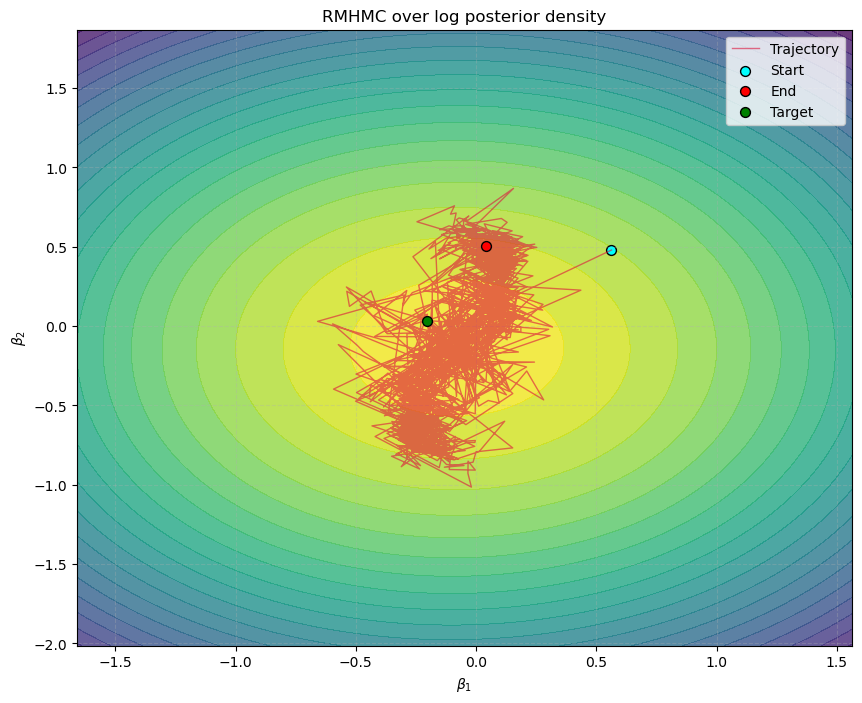

In [38]:
title = "RMHMC over log posterior density"
x_label = r"$\beta_1$"
y_label = r"$\beta_2$"

plot_trajectory_on_density(joint_density,traj[0, :,:], beta_gt, title = title, x_label = x_label, y_label = y_label)

### Autocorrelation of the Markov Chain

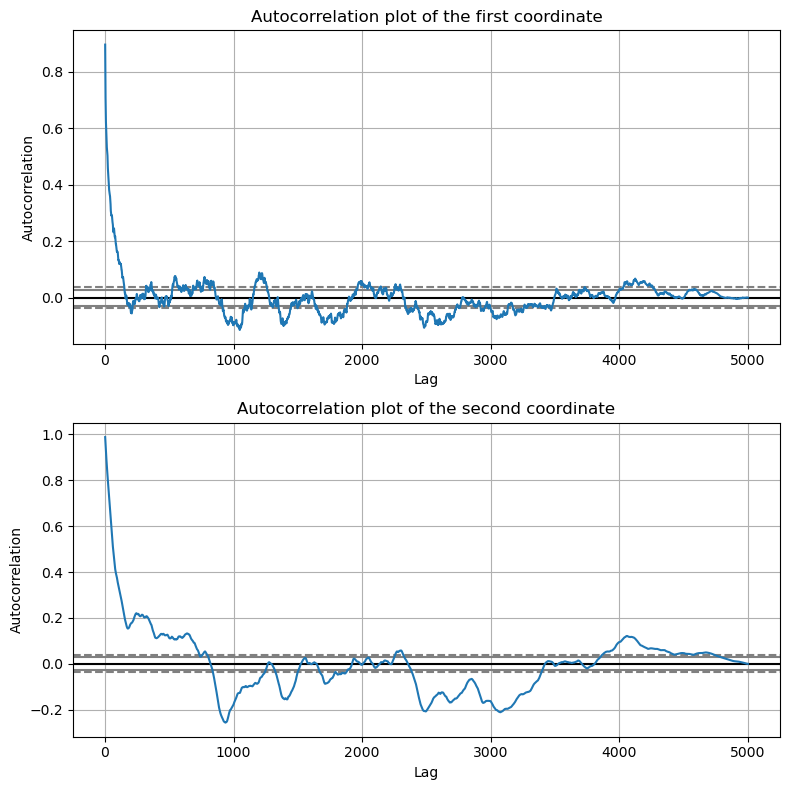

In [39]:
from pandas.plotting import autocorrelation_plot

fig, axs = plt.subplots(2, 1, figsize = (8,8))
autocorrelation_plot(traj[0,:, 0], axs[0])
axs[0].set_title("Autocorrelation plot of the first coordinate")
autocorrelation_plot(traj[0,:, 1], axs[1])
axs[1].set_title("Autocorrelation plot of the second coordinate")
fig.tight_layout()
plt.show()

# II - The ring manifold

In this section we aim at sampling a Riemannian uniform distribution on the thick 2-sphere $S = \{p \in \mathbb R^2 | 1-\alpha <\|p\|<1+\alpha\}$ with $\alpha <1$. We use the following  Riemannian metric which is the Euclidian metric scaled by an inverted bump function that explodes at the border of the manifold. 
\begin{align}
    g_z^{-1}(u,v) = \Psi\left(\frac{\|z\|-1}{\alpha}\right)\langle u, v \rangle_{\R^2}
\end{align}
where $\Psi$ is a bumb function : 
\begin{align}
    \Psi(x) = 
    \begin{cases}
        \exp(\frac{1}{x^2 - 1}) \qquad \text{ if $|x| < 1$} \\
        0 \qquad \text{otherwise}
    \end{cases}
\end{align} 


Other cometric that we test : 
\begin{align}
    h_z^{-1}(u,v) &= 1\!\!1_{[-1, 1]} \star \mathcal N(\cdot |0, \sigma)\left(\frac{\|z\| -1}{\alpha}\right) \langle u, v \rangle_{\mathbb{R}^2} \\
\end{align}
where 
\begin{equation}
    1\!\!1_{[-1, 1]} \star \mathcal N(\cdot |0, \sigma)(x) = \frac{1}{2}\left[\text{erf}\left(\frac{1+x}{\sqrt 2 \sigma}\right) - \text{erf}\left(\frac{1-x}{\sqrt 2 \sigma}\right)\right]
\end{equation}

### Definition of the metric

In [29]:
def bump_fun(x : torch.Tensor) -> torch.Tensor : 
    """ Smooth bump function whose support is ]-1, 1[ : 
    Psi(x) = exp(1/(x^2 -1)) if x in ]-1, 1[ and 0 otherwise

    Args:
        x (torch.Tensor): (Batch of) arguments for the function of shape (N_batch, 1)

    Returns:
        torch.Tensor: (Batch of) outputs of shape (N_batch, 1)
    """ 
    inside = (x > -1) & (x < 1)
    safe_exp = torch.exp(1 / (x**2 - 1))
    return torch.where(inside, safe_exp, torch.zeros_like(x))
 


class RingCometricBump(CoMetric):
    """Implements the Riemannian metric described above on the ring manifold

    Attibutes:
        alpha (torch.Tensor): Half the width of the ring of shape (1,).

        **Inherited Attributes:**
       See :class:`CoMetric` for base CoMetric parameters 
        

    @TO DO : Handle the diag case in the sampler (sampling from moments)
    """

    def __init__(self, alpha : torch.Tensor):
        super().__init__(is_diag = False)
        assert alpha<1
        self.alpha = alpha
        

    def forward(self, p : torch.Tensor) -> torch.Tensor : 
        """Returns the cometric tensor by inverting the metric tensor

        Args:
            p (torch.Tensor):  (Batch of) points on the manifold of shape (N_batch, 2).

        Returns:
            torch.Tensor: (Batch of) cometric tensors of shape (N_batch, 2, 2).
        """
        norm = torch.sqrt(torch.sum(p**2, axis = 1))
        bump_val = bump_fun((1-norm)/self.alpha) 
        I = torch.eye(2).unsqueeze(0)
        return bump_val.view(p.shape[0], 1, 1)*I

In [30]:
from torch.special import erf

def rect_fun(x : torch.Tensor, sigma : torch.Tensor = torch.tensor([0.1]) ) -> torch.Tensor : 
    """ Convolution between a rectangle function and a gaussian of standard deviation sigma

    Args:
        x (torch.Tensor): (Batch of) arguments for the function of shape (N_batch, 1)
        sigma (torch.Tensor) : Standard deviation of the convolution of shape (1,)

    Returns:
        torch.Tensor: (Batch of) outputs of shape (N_batch, 1)
    """ 
    sqrt2 = torch.sqrt(torch.tensor([2]))
    result = 0.5*(erf((x+1)/(sqrt2*sigma)) - erf((x-1)/(sqrt2*sigma)))
    return result
 


class RingCometricRect(CoMetric):
    """Implements the Riemannian metric described above on the ring manifold

    Attibutes:
        alpha (torch.Tensor): Half the width of the ring of shape (1,).

        **Inherited Attributes:**
       See :class:`CoMetric` for base CoMetric parameters 
        

    @TO DO : Handle the diag case in the sampler (sampling from moments)
    """

    def __init__(self, alpha : torch.Tensor):
        super().__init__(is_diag = False)
        assert alpha<1
        self.alpha = alpha
        

    def forward(self, p : torch.Tensor) -> torch.Tensor : 
        """Returns the cometric tensor by inverting the metric tensor

        Args:
            p (torch.Tensor):  (Batch of) points on the manifold of shape (N_batch, 2).

        Returns:
            torch.Tensor: (Batch of) cometric tensors of shape (N_batch, 2, 2).
        """
        norm = torch.sqrt(torch.sum(p**2, axis = 1))
        rect_val = rect_fun((1-norm)/self.alpha) 
        I = torch.eye(2).unsqueeze(0)
        return rect_val.view(p.shape[0], 1, 1)*I

In [31]:
alpha = torch.tensor(0.1) # half width of the ring 

ring_cometric_bump = RingCometricBump(alpha)
ring_cometric_rect = RingCometricRect(alpha)

## 1. RM-HMC with implicit integration scheme

In [32]:
# I think there is an error in the expression of the Kinetic energy of the sampler

class ImplicitRHMCSamplerCorrect(ImplicitRHMCSampler):


    def K(self, v: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the kinetic energy K(v) = - N(v ;0, g(z))
        ie K(v) = 1/2 * v^T g_inv(z) v - 1/2 * log(det(g_inv(z)))

        Parameters
        ----------
        v : Tensor (b,d)
            The velocity.
        z : Tensor (b,d)
            The position.

        Returns
        -------
        kinetic energy : Tensor (b,)
        """
        ####  ERREUR ICI ####
        g_inv = self.cometric(z)
        #####################
        logdet_ginv = torch.logdet(g_inv)
        velocity = torch.einsum("bj,bij,bi->b", v, g_inv, v)
        return 0.5 * velocity - 0.5 * logdet_ginv + 0.5 * v.shape[1] * self.log2pi


In [33]:
l = 10 # Number of leapfrog steps
N_fx = 6 # Number of iteration in the fixed point method
gamma = 0.01 # Step size
N_run = 5000 # Number of Monte Carlo steps
N_chain = 1 # Number of MCMC ran in parallel

sampler_bump = ImplicitRHMCSamplerCorrect(
    cometric = ring_cometric_bump,
    l = l,
    N_fx= N_fx, 
    gamma = gamma, 
    N_run = N_run, 
    #skip_acceptance= True
)

sampler_rect = ImplicitRHMCSamplerCorrect(
    cometric = ring_cometric_rect,
    l = l,
    N_fx= N_fx, 
    gamma = gamma, 
    N_run = N_run, 
    #skip_acceptance= True
)

In [35]:
p_0 = torch.tensor([[0.,1.]])
traj_bump, acc_rate_bump = sampler_bump.sample(p_0, return_traj=True, return_acceptance= True, progress= True)

Sampling: 100%|██████████| 5000/5000 [08:51<00:00,  9.40steps/s, acceptance_rate=0.975]


In [36]:
p_0 = torch.tensor([[0.,1.]])
traj_rect, acc_rate_rect = sampler_rect.sample(p_0, return_traj=True, return_acceptance= True, progress= True)

Sampling: 100%|██████████| 5000/5000 [05:50<00:00, 14.25steps/s, acceptance_rate=0.0568]


### Plot trajectories

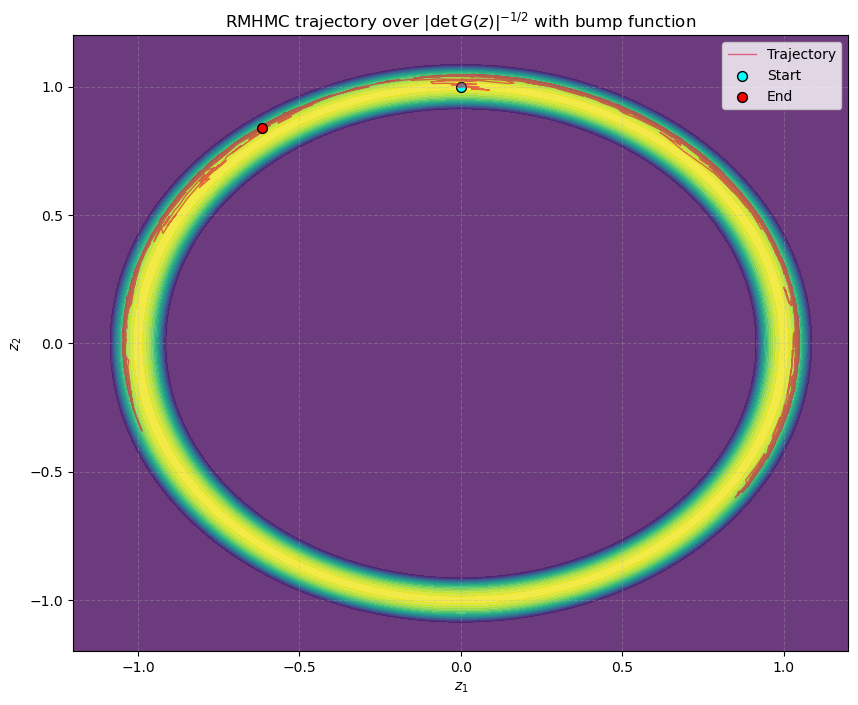

In [39]:
def ring_density_bump(p):
    norm = torch.linalg.norm(p)
    return bump_fun((1-norm)/0.1)

x_lim = (-1.2, 1.2)
y_lim = (-1.2, 1.2)

title = fr"RMHMC trajectory over $|\det G(z)|^{{-1/2}}$ with bump function"
x_label = r"$z_1$"
y_label = r"$z_2$"


plot_trajectory_on_density(ring_density_bump, traj_bump[0,:,:], grid_res= 1000, title = title, x_label = x_label, y_label = y_label, x_lim = x_lim, y_lim = y_lim)

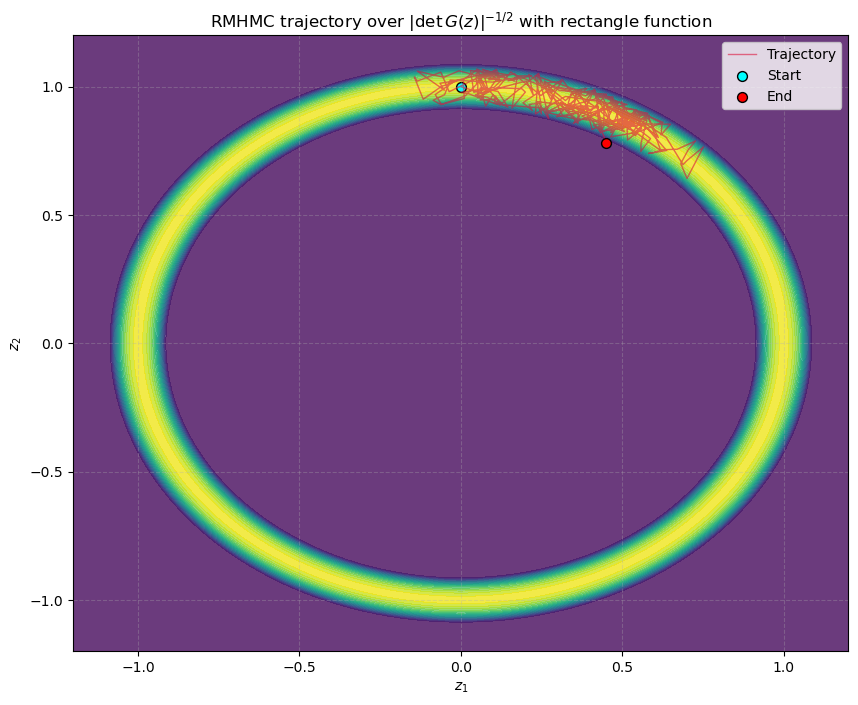

In [40]:
def ring_density_rect(p):
    norm = torch.linalg.norm(p)
    return rect_fun((1-norm)/0.1)

x_lim = (-1.2, 1.2)
y_lim = (-1.2, 1.2)

title = fr"RMHMC trajectory over $|\det G(z)|^{{-1/2}}$ with rectangle function"
x_label = r"$z_1$"
y_label = r"$z_2$"


plot_trajectory_on_density(ring_density_bump, traj_rect[0,:,:], grid_res= 1000, title = title, x_label = x_label, y_label = y_label, x_lim = x_lim, y_lim = y_lim)

### Autocorrelation of the Markov Chain

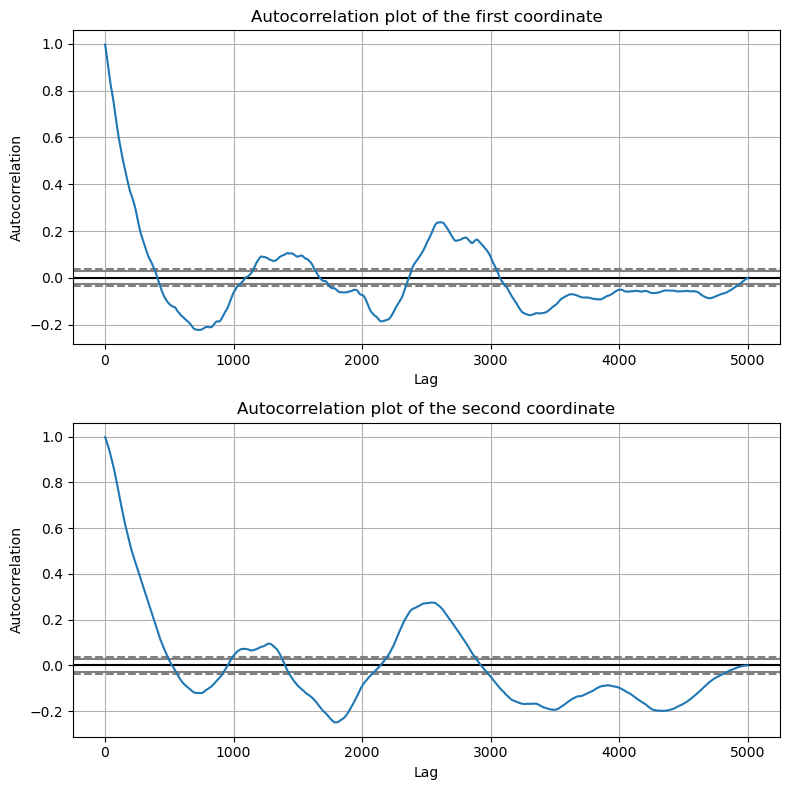

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (8,8))
autocorrelation_plot(traj[0,:, 0], axs[0])
axs[0].set_title("Autocorrelation plot of the first coordinate")
autocorrelation_plot(traj[0,:, 1], axs[1])
axs[1].set_title("Autocorrelation plot of the second coordinate")
fig.tight_layout()
plt.show()

## 2 -Shooting geodesics when adding a Randers covector field

In this subsection we introduce a Randers metric $\mathcal F$ on our previous manifold defined for $z \in S$ and $v \in T_z S$ by : 
\begin{align}
    \mathcal F_z(v) = \|v\|_{g} + \omega_z(v)
\end{align}
Where $g$ is the previous Riemannian metric and $\omega \in \Omega^1(S)$ is the following 1-form : 
\begin{equation}
    \omega = d\theta = \frac{-y}{x^2 + y^2}dx + \frac{x}{x^2 +y^2}dy
\end{equation}
We then experiment the shooting method on this Finsler-Randers manifold.

### Definition of the randers cometric

In [60]:
from geodesic_toolbox import RandersMetrics

# Implementation of the 1-form
class OneForm_dtheta(torch.nn.Module):
    """ Implements the 1-form d theta in cartesian coordinate system.
    """

    def __init__(self):
        super().__init__()
    
    def forward(self, z : torch.Tensor) -> torch.Tensor :
        """Returns the vector representation of the 1-form d theta at a given point. 
        The 1-form is then computed with a dot product : 
        omega_z(v) = <omega(z), v>_g

        Args:
            z (torch.Tensor): (Batch of) points on the manifold of shape (N_batch, 2)

        Returns:
            torch.Tensor: (Batch of) tangent vectors that represent the 1-form of shape (N_batch, 2)
        """
        norm2 = torch.sum(z**2, axis = 1)
        covect = torch.zeros_like(z)
        covect[:, 0] = -z[:,1]/norm2
        covect[:, 1] = z[:,0]/norm2
        return covect



# Definition of the Randers Metric 
class RingRandersMetric(RandersMetrics):
    """_summary_

    Args:
        RandersMetrics (_type_): _description_

    @TO DO: Complete analytical expression of 
    """
    
    def __init__(
        self, 
        base_cometric : RingCometric, 
        omega : OneForm_dtheta, 
        beta : float = 1.0
    ):
        super().__init__(base_cometric=base_cometric, omega = omega, beta = beta)
        self.alpha = self.base_cometric.alpha
        

In [61]:
alpha = torch.tensor([0.1])
base_cometric = RingCometric(alpha)
omega = OneForm_dtheta()
randers_metric = RingRandersMetric(base_cometric, omega)

### Sampling geodesics via shooting 

In [ ]:
from geodesic_toolbox import ExpMapFinsler

class ShootingSampler(torch.nn.Module):
    """_summary_

    Args:
        torch (_type_): _description_
    """

    def __init__(self,  )

# References : 

- [1] Girolami, M., & Calderhead, B. (2011). Riemann Manifold Langevin and Hamiltonian Monte Carlo Methods. Journal of the Royal Statistical Society Series B: Statistical Methodology, 73(2), 123–214. https://doi.org/10.1111/j.1467-9868.2010.00765.x

- [2] Cobb, A. D., Baydin, A. G., Markham, A., & Roberts, S. J. (2019). Introducing an Explicit Symplectic Integration Scheme for Riemannian Manifold Hamiltonian Monte Carlo (arXiv:1910.06243). arXiv. https://doi.org/10.48550/arXiv.1910.06243
